COMP 347 Final Project

(Comparison of ML Methods for Brain Tumor Classification)

* Yash Karandikar
* Pooja Bansiya


1. Data collection and preprocessing

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import random
import matplotlib.pyplot as plt
import pdb
import os
import json
import glob
import random

from PIL import Image
from collections import Counter
import numpy

from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# access secret keys to get API credentials
from google.colab import userdata
KAGGLE_USERNAME = userdata.get('KAGGLE_USERNAME')
print(KAGGLE_USERNAME)

KAGGLE_API_KEY = userdata.get('KAGGLE_API_KEY')

y00shk


In [3]:
# https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab
# https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":KAGGLE_USERNAME,"key":KAGGLE_API_KEY}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json # remove kaggle.json read privileges for security purposes

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 97% 144M/149M [00:01<00:00, 107MB/s] 
100% 149M/149M [00:01<00:00, 97.8MB/s]


In [5]:
# https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [6]:
# load data into Python
# we only want glioma (1) and meningioma (0)
# use glob to load in image data
# https://docs.python.org/3/library/glob.html

# https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
meningiomaX_train = glob.glob('/content/Training/meningioma/*.jpg')
meningiomaY_train = [0] * len(meningiomaX_train)

gliomaX_train = glob.glob('/content/Training/glioma/*.jpg')
gliomaY_train = [1] * len(gliomaX_train)

X_train = meningiomaX_train + gliomaX_train
y_train = meningiomaY_train + gliomaY_train

meningiomaX_test = glob.glob('/content/Testing/meningioma/*.jpg')
meningiomaY_test = [0] * len(meningiomaX_test)

gliomaX_test = glob.glob('/content/Training/glioma/*.jpg')
gliomaY_test = [1] * len(gliomaX_test)

X_test = meningiomaX_test + gliomaX_test
y_test = meningiomaY_test + gliomaY_test

print(X_train[0])
print(y_train[0])
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

/content/Training/meningioma/Tr-me_0051.jpg
0
2660 2660
1627 1627


In [7]:
# shuffle data around
def shuffle_dataset(X, y):
  tuple_list = []

  for i in range(len(y)):
    tuple_list.append((X[i], y[i]))

  random.shuffle(tuple_list)
  X_shuffle = [-1] * len(tuple_list)
  y_shuffle = [-1] * len(tuple_list)

  for i in range(len(tuple_list)):
    X_shuffle[i] = tuple_list[i][0]
    y_shuffle[i] = tuple_list[i][1]

  return [X_shuffle, y_shuffle]

train_lists = shuffle_dataset(X_train, y_train)
X_train = train_lists[0]
y_train = train_lists[1]

test_lists = shuffle_dataset(X_test, y_test)
X_test = test_lists[0]
y_test = test_lists[1]

print(X_train[0:10])
print(y_train[0:10])

print(X_test[0:10])
print(y_test[0:10])

['/content/Training/glioma/Tr-gl_0165.jpg', '/content/Training/meningioma/Tr-me_0089.jpg', '/content/Training/meningioma/Tr-me_0628.jpg', '/content/Training/meningioma/Tr-me_1324.jpg', '/content/Training/glioma/Tr-gl_1320.jpg', '/content/Training/meningioma/Tr-me_0630.jpg', '/content/Training/glioma/Tr-gl_0572.jpg', '/content/Training/glioma/Tr-gl_0504.jpg', '/content/Training/glioma/Tr-gl_0262.jpg', '/content/Training/meningioma/Tr-me_1314.jpg']
[1, 0, 0, 0, 1, 0, 1, 1, 1, 0]
['/content/Training/glioma/Tr-gl_0347.jpg', '/content/Training/glioma/Tr-gl_0522.jpg', '/content/Training/glioma/Tr-gl_1256.jpg', '/content/Testing/meningioma/Te-me_0101.jpg', '/content/Training/glioma/Tr-gl_1238.jpg', '/content/Training/glioma/Tr-gl_0861.jpg', '/content/Training/glioma/Tr-gl_0089.jpg', '/content/Training/glioma/Tr-gl_0476.jpg', '/content/Training/glioma/Tr-gl_0842.jpg', '/content/Testing/meningioma/Te-me_0060.jpg']
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]


2. Collect and process dataset

Approach:
Take strings describing jpg images and get them into pixels.

X_train is going to be a list of lists, each of which has data for each pixel.
- So, X_train[0][0] is the intensity for the first top left pixel in the first image,
- X_train[0][-1] is the intensity for the bottom right pixel in the first image
- X_train[-1][0] is the intensity for the top left pixel in the last image
- X_train[-1][-1] is the intensity for the bottom right pixel in the last image

Sample run (on feature: intensity):
- X_train = [[0 100 55 95 12], [1 15 23 23 12]] (inner list len 512, outer list len 2600)
- y_train = [1 0 1 1 0 ...]
- So [0 100 55 95 12] maps to 1 (tumor present)

Feed this into SVM, logistic regression, K-neighbors, and random forest. Then use ensemble model. The idea is to compare all models' performance on the task.

Pseudocode:

for every image in X_train:

  - for every pixel in image:
  
    - get intensity and put into sublist



In [11]:
def capture_pixel_intensity(img):
  # https://stackoverflow.com/questions/47837808/pil-image-compression
  # https://stackoverflow.com/questions/49565298/pil-valueerror-unknown-resampling-filter-how-to-resize-images-uploaded-on-fla
  IMG_WIDTH = 256
  IMG_LENGTH = 256

  # https://stackoverflow.com/questions/40727793/how-to-convert-a-grayscale-image-into-a-list-of-pixel-values
  open_img = Image.open(img).convert('L')  # convert image to 8-bit grayscale
  resized_img = open_img.resize((IMG_WIDTH, IMG_LENGTH))
  data = list(resized_img.getdata()) # convert image data to a list of integers
  return data

In [9]:
print(len(X_train))
print(len(y_train))
print(len(X_train) == len(y_train))

print(len(X_test))
print(len(y_test))
print(len(X_test) == len(y_test))

2660
2660
True
1627
1627
True


In [12]:
intensityX_train = []
intensityY_train = []
X_train_images = X_train

intensityX_test = []
intensityY_test = []
X_test_images = X_test

for i in range(len(X_train_images)):
  current_pixel_intensity = capture_pixel_intensity(X_train_images[i])
  intensityX_train.append(current_pixel_intensity)
  intensityY_train.append(y_train[i])

for i in range(len(X_test_images)):
  current_pixel_intensity = capture_pixel_intensity(X_test_images[i])
  intensityX_test.append(current_pixel_intensity)
  intensityY_test.append(y_train[i])

print(np.unique(intensityY_train))
print(np.unique(intensityY_test))


[0 1]
[0 1]


In [13]:
print(len(intensityX_train))
print(len(intensityY_train))
print(len(intensityX_test))
print(len(intensityY_test))

2660
2660
1627
1627


3. Compare models (and use ensemble)

In [15]:
data_size = 1000

Support Vector Machine (SVM)

In [16]:
# load data into SVM
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))

In [17]:
clf.fit(intensityX_train[0:data_size], intensityY_train[0:data_size])
y_preds = clf.predict(intensityX_test[0:data_size])
cm = confusion_matrix(intensityY_test[0:data_size], y_preds)

In [18]:
cm

array([[ 71, 169],
       [ 70, 190]])

In [19]:
def show_cm(cm, classes=[0,1]):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classes)
  disp.plot()
  plt.show()

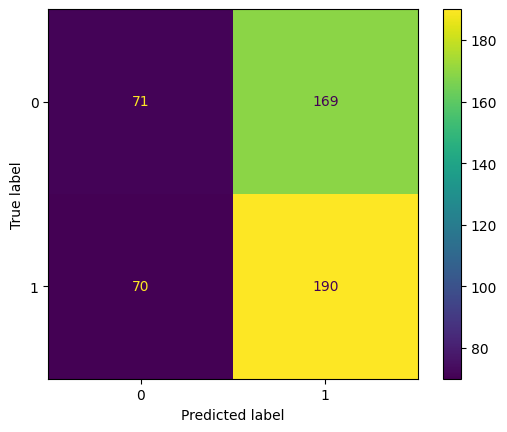

In [20]:
show_cm(cm, [0,1])

In [21]:
# data_size=125
f1_score(intensityY_test[0:data_size], y_preds, average='binary')

0.6138933764135702

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
clf.fit(intensityX_train[0:data_size], intensityY_train[0:data_size])
y_linearsvm_preds = clf.predict(intensityX_test[0:data_size])
cm = confusion_matrix(intensityY_test[0:data_size], y_linearsvm_preds)
show_cm(cm)

Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

new_X_train = preprocessing.StandardScaler().fit_transform(intensityX_train[0:data_size])
new_X_test = preprocessing.StandardScaler().fit_transform(intensityX_test[0:data_size])

lr = LogisticRegression(random_state=0).fit(new_X_train, intensityY_train[0:data_size])
lr_preds = lr.predict(new_X_test)

print(f1_score(intensityY_test[0:data_size], lr_preds, average='binary'))

0.5748709122203097


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


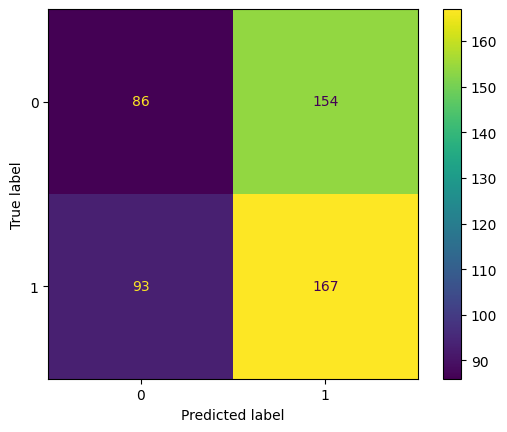

In [23]:
cm = confusion_matrix(intensityY_test[0:data_size], lr_preds)
show_cm(cm, [0, 1])

KNN

In [24]:
# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)  # We can adjust the number of neighbors (n_neighbors) as needed

# Train the KNN model
knn.fit(intensityX_train[0:data_size], intensityY_train[0:data_size])

KNeighborsClassifier(n_neighbors=3)

In [25]:
# Predict using the trained KNN model
knn_preds = knn.predict(intensityX_test[0:data_size])

# Print F1 score for KNN
print("KNN F1 Score:", f1_score(intensityY_test[0:data_size], knn_preds, average='binary'))

KNN F1 Score: 0.6547085201793722


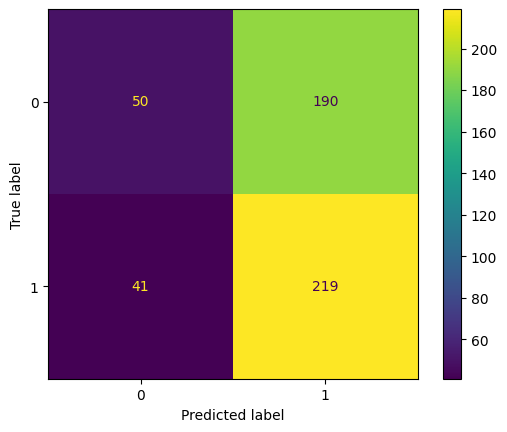

In [26]:
# Display confusion matrix for KNN
cm_knn = confusion_matrix(intensityY_test[0:data_size], knn_preds)
show_cm(cm_knn, classes=[0, 1])

Random Forest F1 Score: 0.6118721461187214


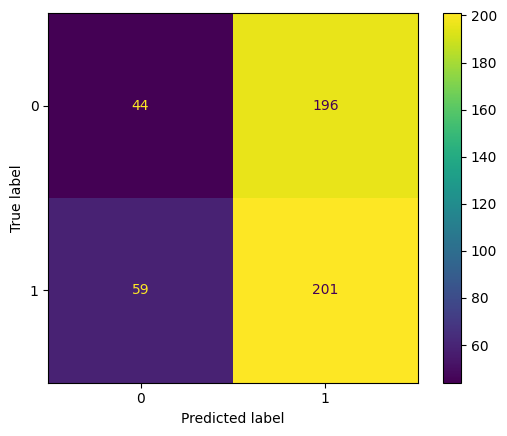

In [27]:
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)  # We can adjust the number of estimators (n_estimators) as needed

# Train the Random Forest model
rf.fit(intensityX_train[0:data_size], intensityY_train[0:data_size])

# Predict using the trained Random Forest model
rf_preds = rf.predict(intensityX_test[0:data_size])

# Print F1 score for Random Forest
print("Random Forest F1 Score:", f1_score(intensityY_test[0:data_size], rf_preds, average='binary'))

# Display confusion matrix for Random Forest
cm_rf = confusion_matrix(intensityY_test[0:data_size], rf_preds)
show_cm(cm_rf, classes=[0, 1])

Ensemble Model

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


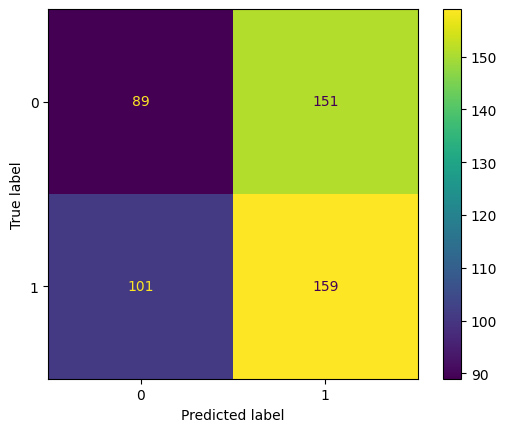

Hard Voting classifier F1 Score: 0.5578947368421052


In [28]:
# finally, do ensemble model using voting classifier

# hard version

new_X_train = preprocessing.StandardScaler().fit_transform(intensityX_train[0:data_size])
new_X_test = preprocessing.StandardScaler().fit_transform(intensityX_test[0:data_size])

from sklearn.ensemble import VotingClassifier
hard_voting_clf = VotingClassifier(
    estimators=[
                 ('svm', clf), ('lr', lr), ('rf', rf), ('knn', knn)], voting='hard'
)

hard_voting_clf.fit(new_X_train, intensityY_train[0:data_size])
hard_voting_preds = hard_voting_clf.predict(new_X_test)

cm_vot = confusion_matrix(intensityY_test[0:data_size], hard_voting_preds)
show_cm(cm_vot, classes=[0,1])

print("Hard Voting classifier F1 Score:", f1_score(intensityY_test[0:data_size], hard_voting_preds, average='binary'))

In [ ]:
# soft version

new_X_train = preprocessing.StandardScaler().fit_transform(intensityX_train[0:data_size])
new_X_test = preprocessing.StandardScaler().fit_transform(intensityX_test[0:data_size])

from sklearn.ensemble import VotingClassifier
soft_voting_clf = VotingClassifier(
    estimators=[
                 ('svm', clf), ('lr', lr), ('rf', rf), ('knn', knn)], voting='soft'
)

soft_voting_clf.fit(new_X_train, intensityY_train[0:data_size])
soft_voting_preds = soft_voting_clf.predict(new_X_test)

cm_vot = confusion_matrix(intensityY_test[0:data_size], soft_voting_preds)
show_cm(cm_vot, classes=[0,1])

print("Soft Voting classifier F1 Score:", f1_score(intensityY_test[0:data_size], soft_voting_preds, average='binary'))

4. Compare different methods

In [30]:
print("RBF kernel SVM: ")
print(f1_score(intensityY_test[0:data_size], y_preds, average='binary'))

print("Linear kernel SVM: ")
print(f1_score(intensityY_test[0:data_size], y_linearsvm_preds, average='binary'))

print("Logistic regression: ")
print(f1_score(intensityY_test[0:data_size], lr_preds, average='binary'))

print("KNN: ")
print(f1_score(intensityY_test[0:data_size], knn_preds, average='binary'))

print("Random forest: ")
print(f1_score(intensityY_test[0:data_size], rf_preds, average='binary'))

print("Hard Voting classifier: ")
print(f1_score(intensityY_test[0:data_size], hard_voting_preds, average='binary'))

print("Soft Voting classifier: ")
print(f1_score(intensityY_test[0:data_size], soft_voting_preds, average='binary'))

RBF kernel SVM: 
0.6138933764135702
Logistic regression: 
0.5748709122203097
KNN: 
0.6547085201793722
Random forest: 
0.6118721461187214
Hard Voting classifier: 
0.5578947368421052
Soft Voting classifier: 


NameError: ignored

TODO

[x] image compression (from 512 x 512 to something like 256 x 256)

[x] try to improve performance (will be easier once whole dataset can be fed in)

[] if have time, try to add additional features (and blend intensity with other features for ML models)